
En este notebook vamos a proponer algunos ejercicios sobre modelos de aprendizaje supervisado utilizando uno de los datasets que ya has visto a lo largo del bootcamp.

# *Adult* [dataset](https://archive.ics.uci.edu/ml/datasets/Adult)


El primer paso es descargarnos los datos y cargarlos en un dataframe de Pandas.

In [45]:
import os
import re
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,auc, confusion_matrix, classification_report

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [18]:
# Creamos una carpeta para que contenga a nuestro dataset
!mkdir /content/adult_dataset
# Movemos el directorio activo a esa localización
%cd /content/adult_dataset
# Descargamos el fichero que contiene los datos a nuestro directorio activo
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
# Descargamos la metadata asociada al conjunto de datos
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
# Leemos datos
with open(os.path.join(os.getcwd(),'adult.data'),'r') as f:
    data = f.read().splitlines() # Dividimos el texto por saltos de línea
    data = [elem.split(',') for elem in data] # Dividimos cada línea por las comas y removemos líneas vacías
# Leemos metadata
with open(os.path.join(os.getcwd(),'adult.names'),'r') as f:
    metadata = f.read().splitlines()
# Regex
regex_fn = lambda text: re.findall('^[a-zA-Z-]+:{1}', text)
reg_text_fn = lambda text : re.findall('[a-zA-Z- ]+', text)
metadata_list = [regex_fn(elem)[0] for elem in metadata if regex_fn(elem)]
col_names = [reg_text_fn(elem)[0] for elem in metadata_list if reg_text_fn(elem)] + ['label']
# Construimos el objeto pd.DataFrame
df = pd.DataFrame(data=data, columns=col_names)

mkdir: cannot create directory ‘/content/adult_dataset’: File exists
/content/adult_dataset
--2022-07-11 10:14:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.2’

adult.data.2        100%[===================>]   3.79M  7.40MB/s    in 0.5s    

2022-07-11 10:14:33 (7.40 MB/s) - ‘adult.data.2’ saved [3974305/3974305]

--2022-07-11 10:14:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adul

In [19]:
# vamos a hacer un poco de exploración de los datos que tenemos, empezando por ver las primeras filas de datos
# que tenemos para hacernos una idea de los datos con los que contamos
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [20]:
# vamos a ver qué información nos puede proporcionar Pandas sobre los datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32562 entries, 0 to 32561
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32562 non-null  object
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  object
 3   education       32561 non-null  object
 4   education-num   32561 non-null  object
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  object
 11  capital-loss    32561 non-null  object
 12  hours-per-week  32561 non-null  object
 13  native-country  32561 non-null  object
 14  label           32561 non-null  object
dtypes: object(15)
memory usage: 3.7+ MB


In [21]:
# Podemos ver que todas las filas menos una contiene información, así que vamos a eliminar esa fila que no contiene información 
# antes de continuar con el procesado de los datos
df = df.dropna()

Vamos a proponer un ejercicio sencillo en el que vamos a intentar predecir si una persona en el dataset tiene unos ingresos por encima de 50K$ o no. Esto viene identificado en el dataset por la columna de label. Más adelante propondremos otros enfoques para que puedas seguir sacando partido a este set de datos y poniendo a punto tus habilidades. 



¿Qúe categoría de problema de aprendizaje supervisado de los que hemos visto en la teoría es el que estamos proponiendo? 

**Un problema de clasificación binaria!**

Al ser un problema de aprendizaje supervisado, vamos a empezar por hacer una validación simple de nuestro modelo utilizando un set de entrenamiento y un set de pruebas.

¿Qué pasos de preprocesamiento de los datos deberíamos aplicar a los datos en tu opinión? **¡Propón tus ideas y debátelo con tus compañeros!**

In [22]:
# empezamos por eliminar columnas que no nos aportan información
df = df.drop(columns=['fnlwgt','education'],axis=1)

# Eliminamos education porque tenemos education_num que nos propociona la misma información y ya tenemos esa columna en un formato numérico
# con lo que no tenemos que hacer nosotros mismos la transformación de la columna de education y podemos eliminarla directamente.

In [23]:
# Tenemos otras variables que son numéricas pero el tipo de datos de las columnas es object, como si fuese un String. Tenemos que corregir el tipo de dato
# de esas variables antes de poder decidir si tenemos que aplicar algún otro paso de preprocesamiento. 
numerical_variables = ['age','education-num', 'capital-gain','capital-loss', 'hours-per-week']

for variable in numerical_variables:
  df[variable] = df[variable].astype(int)

¿Se te ocurre alguna forma de integrar este paso en un pipeline en vez de utilizar un bucle como el que hemos definido? Echa un vistazo a [documentación FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html) y piensa cómo podrías definir una función que haga lo que hace el bucle para una sola columna

In [25]:
# vamos a transformar nuestra variable objetivo, label, para que sea numérica 
label_categories = {' <=50K':0,' >50K':1}
# Vamos a utilizar la función map para transformar las variable del label a numérica
df['label'] = df['label'].map(label_categories)

In [27]:
# Tenemos unas cuantas columnas categóricas, cuyo valor es texto, por lo que vamos a definir un paso en el que apliquemos un one-hot encoding en cada una
# de ellas para poder utilizarlas con nuestro modelo clasificador más adelante. 
categorical_variables = ['workclass', 'marital-status','occupation','relationship','race','sex', 'native-country']

for variable in categorical_variables:
  one_hot_encoding = pd.get_dummies(df[variable])
  df = pd.concat([df, one_hot_encoding], axis=1)
  df= df.drop([variable],axis=1)

Hemos hecho el procesamiento de estas variables categóricas utilizando un bucle igual que en el caso de las variables numéricas. **¿Cómo podríamos integrar esto en un pipeline que junte todos los pasos de preprocesamiento?**

In [39]:
# Ya tenemos nuestros datos preparados para poder sacar resultados, así que vamos a proceder a crear los sets de 
# entrenamiento y de pruebas para realizar una validación simple

y = df['label']
X = df.loc[:, df.columns != 'label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =123)


In [40]:
# Vamos a definir un clasificador de random forest con los hiperparámetros por defecto
rf = RandomForestClassifier()



In [41]:
# vamos a entrenar nuestro modelo con los datos del set de entrenamiento
rf.fit(X_train, y_train)

RandomForestClassifier()

In [42]:
# Ahora vamos a generar predicciones para el set de pruebas
predicciones = rf.predict(X_test)

In [43]:
# ahora vamos a ver qué tal lo ha hecho el random forest
pred_proba = rf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

roc_auc

0.894690475904063

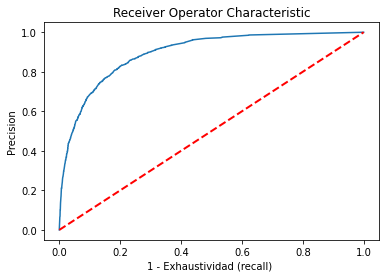

In [46]:
# vamos a pintar la curva del ROC / AUC
plt.plot(fpr,tpr)
plt.plot([0, 1], [0, 1], color='r', lw=2, linestyle='--')
plt.xlabel('1 - Exhaustividad (recall) ')
plt.ylabel('Precision')
plt.title('Receiver Operator Characteristic')
plt.show()

In [47]:
# Otras métrica que podemos sacar son la matriz de confusión del modelo
print(confusion_matrix(y_test, predicciones))

[[4538  389]
 [ 590  996]]


In [49]:
# Scikit-learn también nos permite calcular fácilmente otras métricas como el F1-score, 
# la precisión del modelo y el recall
print(classification_report(y_test, predicciones))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      4927
           1       0.72      0.63      0.67      1586

    accuracy                           0.85      6513
   macro avg       0.80      0.77      0.79      6513
weighted avg       0.84      0.85      0.85      6513



## Otros enfoques

Hemos completado el problema básico con el set de datos que tenemos. Pero hay muchas mejoras que podemos aplicar a la solución que hemos desarrollado: 

- Todos los pasos de preprocesamiento están por separado y utilizando bucles para aplicar ese preprocesamiento a las distintas columnas. Si recuerdas de lo que vimos en la teoría, la utilización de Pipelines es una buena práctica que deberías utilizar siempre. ¿Puedes transformar los pasos de preprocesamiento que hemos aplicado en este ejemplo para que se ejecuten dentro de un Pipeline? 

- Hemos optado por usar un modelo de bosque aleatorio (random forest) con los hiperparámetros por defecto. ¿Puedes encontrar una combinación de hiperparámetros que nos permitan conseguir un mejor resultado? Utiliza un GridSearch como vimos en la teoría y busca la mejor combinación!

- Hemos utilizado el modelo de random forest, que es bastante habitual como valor de referencia a la hora de comparar con otros modelos, pero en la teoría vimos otros modelos que podíamos utilizar para problemas de clasificación. ¿Alguno de esos modelos presentan un desempeño mejor que lo que hemos conseguido con el random forest? No te olvides de optimizar los hiperparámetros de todos los modelos para conseguir los mejores resultados posibles. 

- En este ejemplo hemos optado por utilizar el enfoque de validación simple pero en la teoría hemos visto otros ejemplos de validación que nos permiten entrenar nuestros modelos utilizando todos los datos disponibles sin caer en el overfitting. ¿Conseguimos una mejora del desempeño de nuestros modelos utilizando un tipo diferente de validación como LOOCV o KFCV? 

- Este módulo del bootcamp es una introducción al data science y por lo tanto no hacemos una revisión en detalle de todos los modelos que existen para resolver estos problemas. Sin embargo, hay otro modelo que puede ser interesante en este problema que se llama Support Vector Machine (SVM) que funciona bien en problemas de clasificación binaria como el que tenemos. Esta es la documentación de scikit-learn para un clasificador basado en SVM (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) y esta una descripción de como funciona SVM (https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python) ¿Puedes crear un modelo de clasificación basado en SVM y comparar los resultados con los que has obtenido con los anteriores modelos?